We use gradient descent with backtracking.
See Nocedal, Wright: pg 37.

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import numpy.random as rnd

In [3]:
import pandas as pd
from pandas import Series, DataFrame

In [4]:
from IPython.display import display

In [5]:
from collections import OrderedDict

In [6]:
import matplotlib.pyplot as pl
%matplotlib inline

In [7]:
floatX = np.float32

In [8]:
sess = tf.InteractiveSession()

In [9]:
x = tf.Variable(
    tf.random_normal(shape = [4, 2]), 
    name = "x", dtype = floatX,
)
sess.run(x.initializer)

In [10]:
x_min = np.array([
    [0, 0],
    [3, 3],
    [3, 0],
    [0, 3],
], dtype = floatX)

In [11]:
def fun(x, name = "fun"):
    return tf.reduce_sum((x - x_min)**2, axis = -1, name = name)

In [12]:
f = fun(x)

In [13]:
df = tf.gradients(f, x)[0]

In [14]:
def plot_f(f, x, xxx = np.linspace(-5, 5, 30), yyy = None):
    if yyy is None:
        yyy = xxx
        
    N, dim = sess.run(x).shape
    assert dim == 2
    
    vals = np.empty([N, len(xxx), len(yyy)])
    for i, xx in enumerate(xxx):
        for j, yy in enumerate(yyy):
            vals[:, i, j] = sess.run(f, {x: np.ones([N, 1]) * [xx,yy]})
        
    columns = 2
    rows = int(np.ceil(N / columns))
    fig, axs = pl.subplots(rows, columns, figsize = [columns * 4, rows * 4])
    
    for val, ax in zip(vals, axs.flat):
        ax.pcolormesh(xxx, yyy, val.T)

    return axs

In [15]:
sess.run(f, {x: np.ones([4, 1]) * [0, 0]})

array([ 0., 18.,  9.,  9.], dtype=float32)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B0FFBEC978>,
      dtype=object)

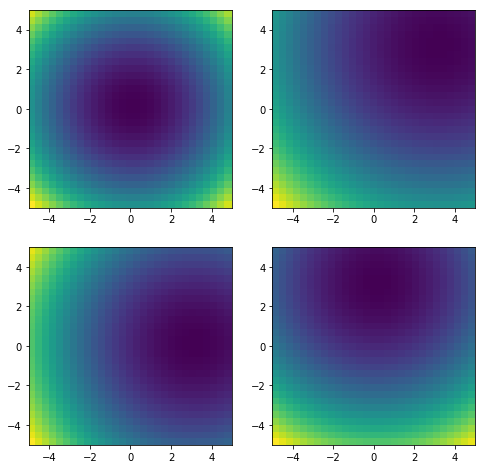

In [16]:
plot_f(f, x)

## Variables we need

In [17]:
using_resource_variables = False

In [18]:
if using_resource_variables:
    Variable = tf.contrib.eager.Variable
    
    x_c = Variable(x, name = "x_c", dtype = floatX, validate_shape=False)
    f_c = Variable(f, name = "f_c", dtype = floatX, validate_shape=False)
    df_c = Variable(x, name = "df_c", dtype = floatX, validate_shape=False)
    x_p = Variable(x, name = "x_p", dtype = floatX, validate_shape=False)
    f_p = Variable(f, name = "f_p", dtype = floatX, validate_shape=False)
    df_p = Variable(x, name = "df_p", dtype = floatX, validate_shape=False)
    condition = Variable(tf.ones_like(f, dtype = bool), name = "condition", dtype = tf.bool, validate_shape=False)
    alpha = Variable(tf.ones_like(f), name = "alpha", dtype = floatX, validate_shape=False)
else:
    x_c = tf.Variable(x, name = "x_c", dtype = floatX, validate_shape=False)
    x_c.set_shape([None, None])

    f_c = tf.Variable(f, name = "f_c", dtype = floatX, validate_shape=False)
    f_c.set_shape([None])

    df_c = tf.Variable(x, name = "df_c", dtype = floatX, validate_shape=False)
    df_c.set_shape([None, None])

    x_p = tf.Variable(x, name = "x_p", dtype = floatX, validate_shape=False)
    x_p.set_shape([None, None])

    f_p = tf.Variable(f, name = "f_p", dtype = floatX, validate_shape=False)
    f_p.set_shape([None])

    df_p = tf.Variable(x, name = "df_p", dtype = floatX, validate_shape=False)
    df_p.set_shape([None, None])

    condition = tf.Variable(tf.ones_like(f, dtype = bool), name = "condition", dtype = tf.bool, validate_shape=False)
    condition.set_shape([None])

    alpha = tf.Variable(tf.ones_like(f), name = "alpha", dtype = floatX, validate_shape=False)
    alpha.set_shape([None])

In [19]:
def plot_training():
    axs = plot_f(f, x)
    for ax, xc, xp in zip(axs.flat, *sess.run([x_c, x_p])):
        ax.scatter(*xc)
        ax.scatter(*xp)
    

In [20]:
def display_vars():
    df = DataFrame(OrderedDict([
        ["x", list(x.eval())],
        ["x_c", list(x_c.eval())],
        ["x_p", list(x_p.eval())],
        
        ["f", list(f.eval())],
        ["f_c", list(f_c.eval())],
        ["f_p", list(f_p.eval())],
       
        ["alpha", alpha.eval()],
        ["cond", condition.eval()]
    ]))
    display(df) 

## Initialization node

In [21]:
initial_step_length = 5
minimal_grad_length = 1e-5
c1 = sufficient_descent_const = 0.5
rho = step_contraction_factor = 0.5

In [22]:
# tf.assign(
#     x_c, x, validate_shape = False
# )

<tf.Tensor 'Assign:0' shape=(4, 2) dtype=float32_ref>

In [23]:
initialization = tf.group(
    *[
        tf.assign(
            var, val, name = name + "_initializer", 
            validate_shape=False
        )
        for var, val, name in [
            [x_c, x, "x_c"],
            [f_c, f, "f_c"],
            [df_c, df, "df_c"],

            [x_p, x, "x_p"],
            [f_p, f, "f_p"],
            [df_p, df, "df_p"],        
        ]
    ], 
    tf.assign(
        alpha,
        initial_step_length / tf.maximum(minimal_grad_length, tf.norm(df, axis = -1)),
        name = "alpha_initializer", 
        validate_shape = False
    ),
    tf.assign(
        condition, tf.cast(tf.ones_like(f), tf.bool), 
        validate_shape=False),
    name = "initialization"
)

In [24]:
x_init = tf.assign(x, np.ones([4, 2]))

In [25]:
# init = tf.group(
#     *[
#         var.initializer for var in [
#             x_c, f_c, df_c, x_p, f_p, df_p, condition, alpha 
#         ]
#     ],
#     name = "init"
# )

# Training step as a sequence of operations

In [26]:
def ass():
    assert (sess.run(f, {x: x_c.eval()}) == sess.run(f_c)).all()
    assert (sess.run(f, {x: x_p.eval()}) == sess.run(f_p)).all()
    
    assert (sess.run(df, {x: x_c.eval()}) == sess.run(df_c)).all()
    assert (sess.run(df, {x: x_p.eval()}) == sess.run(df_p)).all()

$$x_p := x_c - \alpha\cdot df_c$$

In [27]:
s1 = tf.assign(x_p, x_c - alpha[:, None] * df_c)

$$f_p := f(x_p)$$
$$df_p := df(x_p)$$

In [28]:
s2 = tf.assign(x, x_p + 1 - 1)
 

In [29]:
s3 = tf.group(
    tf.assign(f_p, f + 1 - 1, name = "evaluate_f_p"),
    tf.assign(df_p, df + 1 - 1, name = "evaluate_df_p")
)

Sufficient descent condition is:
$$f_p \leq f_c + c_1 (x_p - x_c)\cdot df_c $$
If it is satisfied then:
$$x_c := x_p; \quad f_c := f_p; \quad df_c := df_p; \quad \alpha := \alpha; \quad  $$
otherwise
$$x_c := x_c; \quad f_c := f_c; \quad df_c := df_c; \quad \alpha := \rho\cdot \alpha; \quad  $$

In [30]:
s4 = tf.assign(
        condition,
        f_p <= f_c + c1 * tf.einsum("bi,bi->b", x_p - x_c, df_c),
        name = "evaluate_condition",
        validate_shape = True,
    )
  

In [31]:
condition2 = tf.cast(
    tf.cast(condition[:, None], tf.int32) * tf.ones_like(x, tf.int32),
    bool
)

s5 = tf.group(
        tf.assign(x_c, tf.where(condition2, x_p, x_c)),
        tf.assign(f_c, tf.where(condition, f_p, f_c)),
        tf.assign(df_c, tf.where(condition2, df_p, df_c)),
        tf.assign(alpha, tf.where(condition, alpha, rho * alpha)),
    )

In [40]:
s6 = tf.assign(x, x_c)

In [32]:
sequence = [s1, s2, s3, s4, s5, s6]

In [33]:
sess.run(x_init)
sess.run(initialization)
display_vars()

,x,x_c,x_p,f,f_c,f_p,alpha,cond
0,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]",2.0,2.0,2.0,1.767767,True
1,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]",8.0,8.0,8.0,0.883883,True
2,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]",5.0,5.0,5.0,1.118034,True
3,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]",5.0,5.0,5.0,1.118034,True


,x,x_c,x_p,f,f_c,f_p,alpha,cond
0,"[0.00018179417, 0.00018179417]","[0.00018181803, 0.00018181803]","[0.00018181803, 0.00018181803]",6.609824e-08,1.192093e-07,1.192093e-07,0.441942,True
1,"[2.9999578, 2.9999578]","[2.9999578, 2.9999578]","[2.9999578, 2.9999578]",3.561695e-09,0.000000e+00,0.000000e+00,0.441942,True
2,"[2.924366, 0.037817]","[2.924366, 0.037817005]","[2.924366, 0.037817005]",7.150628e-03,7.150650e-03,7.150650e-03,0.279509,True
3,"[0.037817, 2.924366]","[0.037817005, 2.924366]","[0.037817005, 2.924366]",7.150628e-03,7.150650e-03,7.150650e-03,0.279509,True


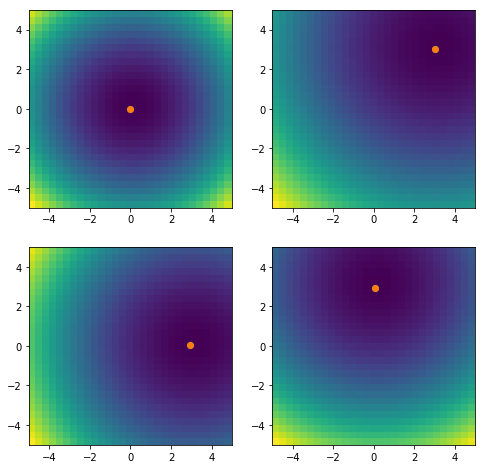

In [39]:
for s in sequence:
    sess.run(s)
display_vars()
plot_training()

# Put it into a neat Python class

In [41]:
from gradient_descent_with_backtracking import GragientDescentWithBackTracking

optimizer = GragientDescentWithBackTracking(x, f, df)
optimizer.initializer = optimizer.construct_initializer()
optimizer.step_sequence = optimizer.construct_step_sequence()

In [48]:
def plot_training2():
    axs = plot_f(f, x)
    for ax, xx in zip(axs.flat, sess.run(x)):
        ax.scatter(*xx)

In [52]:
sess.run(x_init)
sess.run(optimizer.initializer)

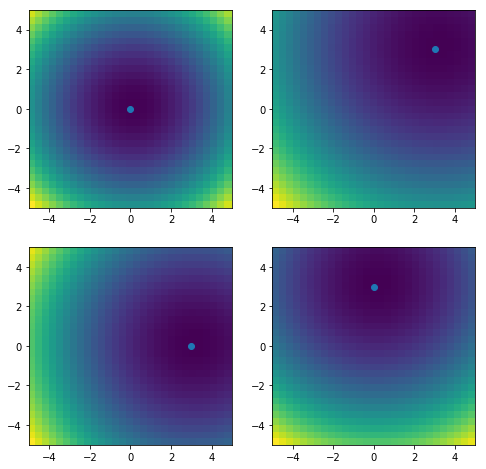

In [66]:
for s in optimizer.step_sequence:
    sess.run(s)

plot_training2()

# Training step in one operation
I could not make `tensorflow` execute my operations in the correc order.

In [24]:
def ass():
    assert (sess.run(f, {x: x_c.eval()}) == sess.run(f_c)).all()
    assert (sess.run(f, {x: x_p.eval()}) == sess.run(f_p)).all()
    
    assert (sess.run(df, {x: x_c.eval()}) == sess.run(df_c)).all()
    assert (sess.run(df, {x: x_p.eval()}) == sess.run(df_p)).all()

$$x_p := x_c - \alpha\cdot df_c$$

In [25]:
propose_x_p = tf.assign(x_p, x_c - alpha[:, None] * df_c)

$$f_p := f(x_p)$$
$$df_p := df(x_p)$$

In [26]:
with tf.control_dependencies([propose_x_p]):
    assign_xp_to_x = tf.assign(x, x_p + 1 - 1)
 

In [27]:
with tf.control_dependencies([assign_xp_to_x]):
    evaluate_f_at_x_p = tf.assign(f_p, f + 1 - 1, name = "evaluate_f_p")
    evaluate_df_at_x_p = tf.assign(df_p, df + 1 - 1, name = "evaluate_df_p")


Sufficient descent condition is:
$$f_p \leq f_c + c_1 (x_p - x_c)\cdot df_c $$
If it is satisfied then:
$$x_c := x_p; \quad f_c := f_p; \quad df_c := df_p; \quad \alpha := \alpha; \quad  $$
otherwise
$$x_c := x_c; \quad f_c := f_c; \quad df_c := df_c; \quad \alpha := \rho\cdot \alpha; \quad  $$

In [28]:
with tf.control_dependencies([evaluate_f_at_x_p, evaluate_df_at_x_p]):
    evaluate_condition = tf.assign(
        condition,
        f_p <= f_c + c1 * tf.einsum("bi,bi->b", x_p - x_c, df_c),
        name = "evaluate_condition",
        validate_shape = True,
    )
  

In [29]:
with tf.control_dependencies([evaluate_condition]):
    train_step = tf.group(
        tf.assign(x_c, tf.where(condition, x_p, x_c)),
        tf.assign(f_c, tf.where(condition, f_p, f_c)),
        tf.assign(df_c, tf.where(condition, df_p, df_c)),
        tf.assign(alpha, tf.where(condition, alpha, rho * alpha)),
    )

**In the following cell, you can see the problem with the order of execution**

In [42]:
sess.run(x_init)
sess.run(initialization)
display_vars()

# sess.run(propose_x_p)
# sess.run(assign_xp_to_x)
sess.run(evaluate_f_at_x_p)
display_vars()

,x,x_c,x_p,f,f_c,f_p,alpha,cond
0,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]",2.0,2.0,2.0,0.176777,True
1,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]",8.0,8.0,8.0,0.088388,True
2,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]",5.0,5.0,5.0,0.111803,True
3,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]",5.0,5.0,5.0,0.111803,True


,x,x_c,x_p,f,f_c,f_p,alpha,cond
0,"[0.6464466, 0.6464466]","[1.0, 1.0]","[0.6464466, 0.6464466]",0.835786,2.0,2.0,0.176777,True
1,"[1.3535533, 1.3535533]","[1.0, 1.0]","[1.3535534, 1.3535534]",5.421574,8.0,8.0,0.088388,True
2,"[1.4472136, 0.7763932]","[1.0, 1.0]","[1.4472136, 0.7763932]",3.013932,5.0,5.0,0.111803,True
3,"[0.7763932, 1.4472136]","[1.0, 1.0]","[0.7763932, 1.4472136]",3.013932,5.0,5.0,0.111803,True


,x,x_c,x_p,f,f_c,f_p,alpha,cond
0,"[-0.66710806, 0.0024599012]","[-0.66710806, 0.0024599012]","[-0.66710806, 0.0024599012]",0.445039,0.445039,0.445039,0.374749,True
1,"[-1.3858104, -0.20204143]","[-1.3858104, -0.20204143]","[-1.3858104, -0.20204143]",29.488401,29.488401,29.488401,0.046038,True
2,"[-0.49497625, 1.335943]","[-0.49497625, 1.335943]","[-0.49497625, 1.335943]",13.999602,13.999602,13.999602,0.066816,True
3,"[-0.6072379, -1.9096935]","[-0.6072379, -1.9096935]","[-0.6072379, -1.9096935]",24.473831,24.473831,24.473831,0.050535,True


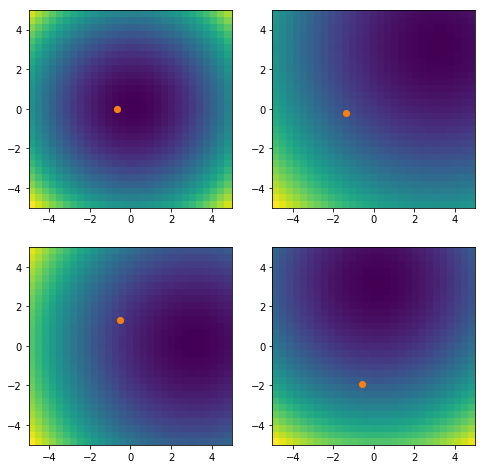

In [44]:
sess.run(x.initializer)
sess.run(initialization)
ass()
plot_training()
display_vars()

,x,x_c,x_p,f,f_c,f_p,alpha,cond
0,"[-0.16711146, 0.0006161928]","[-0.66710806, 0.0024599012]","[-0.16711146, 0.00061620853]",0.027927,0.445039,0.445039,0.187375,False
1,"[-0.9819844, 0.09278834]","[-1.3858104, -0.20204143]","[-0.9819844, 0.09278835]",24.308079,29.488401,29.488401,0.023019,False
2,"[-0.027933836, 1.1574175]","[-0.49497625, 1.335943]","[-0.027933806, 1.1574175]",10.507999,13.999602,13.999602,0.033408,False
3,"[-0.5458648, -1.4134744]","[-0.6072379, -1.9096935]","[-0.5458648, -1.4134744]",19.776726,24.473831,24.473831,0.025267,False


AssertionError: 

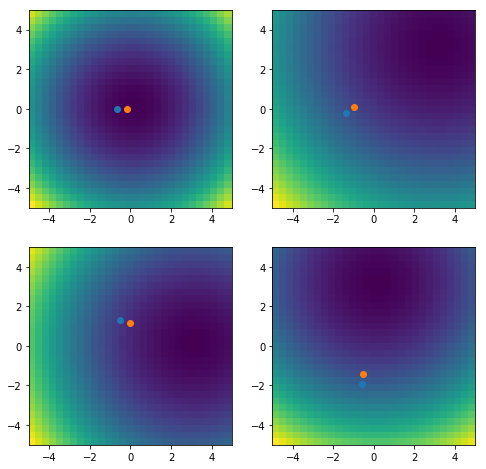

In [45]:
sess.run(train_step)
plot_training()
display_vars()
ass()


In [ ]:
disp

In [36]:
sess.run(x.initializer)
sess.run(initialization)
ass()
sess.run(evaluate_at_x_p)
ass()


AssertionError: 

In [37]:
sess.run([x, x_p, x_c])

[array([[ 0.63110256,  0.07622039],
        [-0.3890109 ,  0.9464245 ],
        [ 1.3597765 , -1.5865178 ],
        [-0.18697214, -0.37484276]], dtype=float32),
 array([[ 0.63110256,  0.07622041],
        [-0.38901088,  0.9464244 ],
        [ 1.3597766 , -1.5865178 ],
        [-0.18697217, -0.37484276]], dtype=float32),
 array([[ 1.1274954 ,  0.13617148],
        [-0.8166305 ,  0.6873078 ],
        [ 1.0003885 , -1.9341385 ],
        [-0.21463063, -0.8740772 ]], dtype=float32)]

In [38]:
sess.run([f, f_p, f_c])

[array([ 0.4041   , 15.702567 ,  5.2073717, 11.424521 ], dtype=float32),
 array([ 1.2897885, 19.915213 ,  7.739338 , 15.054543 ], dtype=float32),
 array([ 1.2897885, 19.915213 ,  7.739338 , 15.054542 ], dtype=float32)]

In [28]:
s1 = tf.assign(x_p, x_c - alpha[:, None] * df_c)

In [29]:
s2 = tf.assign(x, x_p)

In [30]:
s3 = tf.group(
    tf.assign(f_p, f, name = "evaluate_f_p"),
    tf.assign(df_p, df, name = "evaluate_df_p"),
    name = "evaluate_at_x_p",
)

In [31]:
s4 = tf.assign(
    condition, 
    f_p <= f_c + c1 * tf.einsum("bi,bi->b", x_p - x_c, df_c),
    name = "condition_evaluation"
)
s5 = tf.group(
    tf.assign(x_c, tf.where(condition, x_p, x_c)),
    tf.assign(f_c, tf.where(condition, f_p, f_c)),
    tf.assign(df_c, tf.where(condition, df_p, df_c)),
    tf.assign(alpha, tf.where(condition, alpha, rho * alpha)),
)

In [ ]:
sess.run(x.initializer)
sess.run(initialization)
plot_training()
display_vars()
assert (sess.run(f, {x: x_c.eval()}) == sess.run(f_c)).all()

,x_c,x_p,alpha
0,"[-0.001545786, 0.0039919917]","[-0.00092319946, 0.002384162]",0.201382
1,"[1.8525785, 1.8386115]","[1.9652777, 1.9526825]",0.049110
2,"[2.551509, 0.32119203]","[2.6190372, 0.27283096]",0.075284
3,"[-0.01296819, 2.9859216]","[-0.0087112505, 2.990543]",0.164130


[ True  True  True  True]


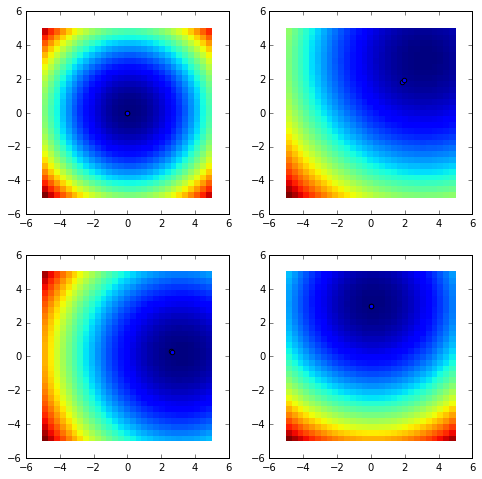

In [45]:
sess.run(s1)
sess.run(s2)
sess.run(s3)
ass()

plot_training()
display_vars()

sess.run(s4)
ass()
print(condition.eval())

sess.run(s5)
ass()


In [46]:
steps = [s1, s2, s3, s4, s5]

In [56]:
cs1 = tf.identity(s1, "cs1")

In [58]:
with tf.control_dependencies([cs1]):
    cs2 = tf.identity(s2, "cs2")

In [60]:
with tf.control_dependencies([cs2]):
    cs3 = tf.group(s3, name = "cs3")

In [61]:
with tf.control_dependencies([cs3]):
    cs4 = tf.identity(s4, name = "cs4")

In [62]:
with tf.control_dependencies([cs4]):
    cs5 = tf.group(s5, name = "cs5")

In [67]:
ass()
sess.run(cs3)
ass()

plot_training()
display_vars()

AssertionError: 

In [71]:
cum_steps = [tf.Print(s1, [], "cs1")]
for s in steps[1:]:
    with tf.control_dependencies([cum_steps[-1]]):
        cs = tf.group(
            s,
            tf.Print(1,[], message = "cs{}".format(len(cum_steps) + 2))
        )
        cum_steps.append(cs)
    

In [74]:
sess.run(cs1)

array([[ 0.07502855, -0.31464154],
       [-0.05093732, -0.7964755 ],
       [ 1.0402911 , -0.15530856],
       [ 2.1225262 ,  0.7704322 ]], dtype=float32)

In [53]:
cum_steps = [tf.Print(s1, [], message = "cs1")]
for s in steps[1:]:
    with tf.control_dependencies([cum_steps[-1]]):
        cs = tf.Print(s, [], message = "cs{}".format(len(cum_steps) + 2))
        cum_steps.append(cs)
    

TypeError: Can't convert Operation 'evaluate_at_x_p' to Tensor (target dtype=None, name='input', as_ref=False)

# Bordel

In [55]:
a = tf.Variable(1)
sess.run(a, {a: 2})

array(2)

In [ ]:
b = tf.contrib.eager.Variable(1)
b1 = b + 1

In [59]:
sess.run(b.initializer)
sess.run(b1, {b: 10})

2